In [17]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import seaborn as sns
import folium
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
data = pd.read_csv('geo_census.csv', index_col = False)

In [19]:
data.head()

,d,s,p,pop,hhs,fem_hhs,long,lat,km2,area,...,kitch_open_space_per_km,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid
0,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,490.22,5813.62,1405.81,4.14,10.85,9.75,0.19,0.17,"POLYGON((32.5252889374246 0.334884258953588, 3...",POINT(32.5133620505223 0.356148577052009)
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,35.28,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355)
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,454.04,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633)
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,1.67,7666.06,746.45,10.27,9.14,9.14,0.12,0.12,"POLYGON((32.6390124439034 0.287753994240262, 3...",POINT(32.6401789189264 0.298033199468685)
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,88.35,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354)


In [20]:
data.columns

Index(['d', 's', 'p', 'pop', 'hhs', 'fem_hhs', 'long', 'lat', 'km2', 'area',
       'perimeter', 'T123', 'not_T123', 'light_gas_pc', 'light_gas_per_km',
       'light_lpg_pc', 'light_lpg_per_km', 'light_biogas_pc',
       'light_biogas_per_km', 'light_par_lantern_pc',
       'light_par_lantern_per_km', 'light_par_tadooba_pc',
       'light_par_tadooba_per_km', 'light_candles_pc', 'light_candles_per_km',
       'light_firewood_pc', 'light_firewood_per_km', 'light_cow_dung_pc',
       'light_cow_dung_per_km', 'light_grass_pc', 'light_grass_per_km',
       'cook_elec_therm_pc', 'cook_elec_therm_per_km', 'cook_gas_pc',
       'cook_gas_per_km', 'cook_lpg_pc', 'cook_lpg_per_km', 'cook_biogas_pc',
       'cook_biogas_per_km', 'cook_par_lantern_pc', 'cook_par_lantern_per_km',
       'cook_charc_pc', 'cook_charc_per_km', 'cook_firewood_pc',
       'cook_firewood_per_km', 'cook_dung_pc', 'cook_dung_per_km',
       'cook_grass_pc', 'cook_grass_per_km', 'waste_burn_pc',
       'waste_burn_per_km'

In [21]:
data.shape

(116, 66)

## Feature engineering

In [22]:
for column in data.columns:
    if '_pc' in column:
        data.drop(column, axis = 1, inplace = True)

In [23]:
data.rename(columns = {'d': 'district', 's': 'subcounty', 'p':'parish', 'pop':'population', 'hhs':'households'}, inplace = True)
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,kitch_open_space_per_km,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid
0,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,490.22,5813.62,1405.81,4.14,10.85,9.75,0.19,0.17,"POLYGON((32.5252889374246 0.334884258953588, 3...",POINT(32.5133620505223 0.356148577052009)
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,35.28,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355)
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,454.04,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633)
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,1.67,7666.06,746.45,10.27,9.14,9.14,0.12,0.12,"POLYGON((32.6390124439034 0.287753994240262, 3...",POINT(32.6401789189264 0.298033199468685)
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,88.35,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354)


In [24]:
data.dropna(axis=0, inplace=True)
data = data.reset_index(drop=True)
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,kitch_open_space_per_km,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid
0,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,490.22,5813.62,1405.81,4.14,10.85,9.75,0.19,0.17,"POLYGON((32.5252889374246 0.334884258953588, 3...",POINT(32.5133620505223 0.356148577052009)
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,35.28,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355)
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,454.04,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633)
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,1.67,7666.06,746.45,10.27,9.14,9.14,0.12,0.12,"POLYGON((32.6390124439034 0.287753994240262, 3...",POINT(32.6401789189264 0.298033199468685)
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,88.35,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354)


In [25]:
#extracting x, y and z coordinates to replace latitude and longitude 
data['coord_x'] = np.cos(data['lat']) * np.cos(data['long'])
data['coord_y'] = np.cos(data['lat']) * np.sin(data['long'])
data['coord_z'] = np.sin(data['lat'])
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid,coord_x,coord_y,coord_z
0,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,4.14,10.85,9.75,0.19,0.17,"POLYGON((32.5252889374246 0.334884258953588, 3...",POINT(32.5133620505223 0.356148577052009),0.427272,0.834188,0.348667
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355),0.266405,0.906592,0.327290
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633),0.328582,0.872929,0.360595
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,10.27,9.14,9.14,0.12,0.12,"POLYGON((32.6390124439034 0.287753994240262, 3...",POINT(32.6401789189264 0.298033199468685),0.324676,0.899089,0.293641
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354),0.338856,0.877348,0.339761


### data visualization

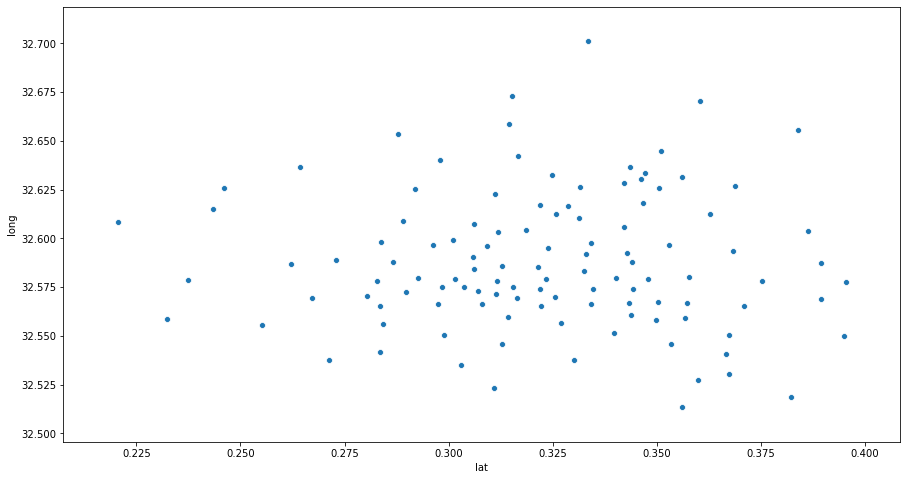

In [26]:
plt.figure(figsize = (15,8))
sns.scatterplot(data['lat'], data['long'])

In [27]:
# display coordinates on map of kampala
map_pickup = folium.Map( location=[0.3476,32.5825])
data.apply(lambda row:folium.CircleMarker(location=[row['lat'], row['long']] ).add_to(map_pickup), axis=1)
# optional: save the map.
map_pickup.save('map_pickup.html')
map_pickup

## Running the clustering model

In [28]:
#data to be used for clustering
X = data[['coord_x', 'coord_y', 'coord_z', 'light_par_tadooba_per_km', 'light_firewood_per_km', 'light_cow_dung_per_km', 
          'light_grass_per_km', 'cook_charc_per_km', 'cook_firewood_per_km', 'cook_dung_per_km', 'cook_grass_per_km', 
          'waste_burn_per_km', 'kitch_outside_built_per_km', 'kitch_make_shift_per_km', 'kitch_open_space_per_km', 
          'pop_density', 'hhs_density', 'T123_per_sqkm']]
X.head()

,coord_x,coord_y,coord_z,light_par_tadooba_per_km,light_firewood_per_km,light_cow_dung_per_km,light_grass_per_km,cook_charc_per_km,cook_firewood_per_km,cook_dung_per_km,cook_grass_per_km,waste_burn_per_km,kitch_outside_built_per_km,kitch_make_shift_per_km,kitch_open_space_per_km,pop_density,hhs_density,T123_per_sqkm
0,0.427272,0.834188,0.348667,92.37,2.09,0.00,0.10,1220.60,89.99,0.1,0.0,1001.49,509.36,74.56,490.22,5813.62,1405.81,10.85
1,0.266405,0.906592,0.327290,11.66,0.19,0.00,0.05,95.64,25.93,0.0,0.0,79.32,55.84,11.66,35.28,605.86,136.01,3.44
2,0.328582,0.872929,0.360595,33.02,2.06,0.00,0.00,1069.40,52.97,0.0,0.0,324.71,345.00,46.78,454.04,5818.23,1546.83,13.83
3,0.324676,0.899089,0.293641,0.56,0.00,0.00,0.00,58.32,1.11,0.0,0.0,203.83,157.18,2.78,1.67,7666.06,746.45,9.14
4,0.338856,0.877348,0.339761,1.11,0.00,0.37,0.00,289.19,12.25,0.0,0.0,109.88,46.03,13.36,88.35,1951.55,503.39,15.48


In [29]:
# perform normalization on input features and present as dataframe
#X = StandardScaler().fit_transform(X)

In [31]:
#Scaling
from sklearn.preprocessing import normalize
X_scaled= normalize(X)
X_scaled= pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,coord_x,coord_y,coord_z,light_par_tadooba_per_km,light_firewood_per_km,light_cow_dung_per_km,light_grass_per_km,cook_charc_per_km,cook_firewood_per_km,cook_dung_per_km,cook_grass_per_km,waste_burn_per_km,kitch_outside_built_per_km,kitch_make_shift_per_km,kitch_open_space_per_km,pop_density,hhs_density,T123_per_sqkm
0,0.000069,0.000134,0.000056,0.014831,0.000336,0.000000,0.000016,0.195982,0.014449,0.000016,0.0,0.160801,0.081784,0.011972,0.078711,0.933448,0.225720,0.001742
1,0.000418,0.001422,0.000513,0.018292,0.000298,0.000000,0.000078,0.150039,0.040679,0.000000,0.0,0.124436,0.087601,0.018292,0.055347,0.950465,0.213371,0.005397
2,0.000053,0.000142,0.000059,0.005369,0.000335,0.000000,0.000000,0.173880,0.008613,0.000000,0.0,0.052797,0.056096,0.007606,0.073825,0.946022,0.251509,0.002249
3,0.000042,0.000117,0.000038,0.000073,0.000000,0.000000,0.000000,0.007567,0.000144,0.000000,0.0,0.026448,0.020395,0.000361,0.000217,0.994708,0.096855,0.001186
4,0.000166,0.000430,0.000166,0.000544,0.000000,0.000181,0.000000,0.141648,0.006000,0.000000,0.0,0.053820,0.022546,0.006544,0.043275,0.955890,0.246566,0.007582


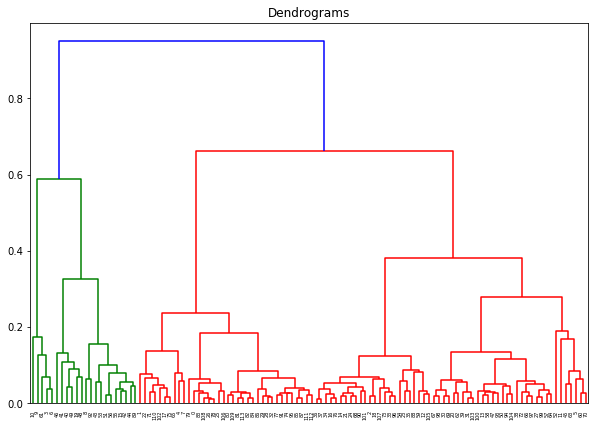

In [32]:
#Finding out the optimal number of clusters
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(X_scaled, method='ward'))

In [34]:
#perform normalization on input features and present as dataframe
X_scaled2 = StandardScaler().fit_transform(X)

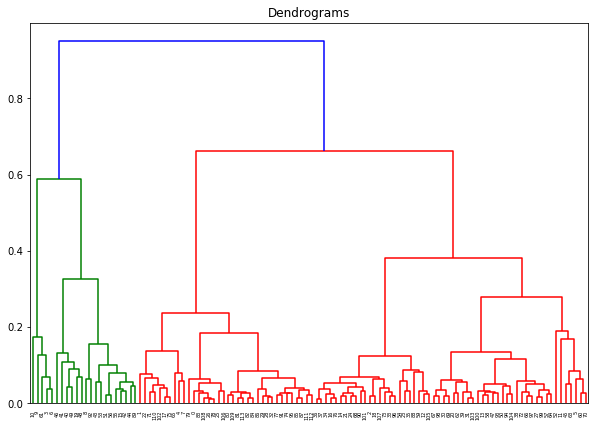

In [35]:
#Finding out the optimal number of clusters
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(X_scaled, method='ward'))

In [36]:
# running the hierarchical clustering model
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
clusters = cluster.fit_predict(X_scaled2)

In [159]:
# identifying values of final centroids in each cluster
print (len(clusters))

114


In [160]:
# Reconstructing df naming clusters
data['cluster'] =clusters
#data['cluster'] = data['cluster'].astype(str)
data.head()

,index,district,subcounty,parish,population,households,long,lat,km2,area,...,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid,cluster
0,0,WAKISO,WAKISO,KYEBANDO,61051,14763,32.513362,0.356149,10.501383,10.412916,...,5813.62,1405.81,4.14,10.85,9.75,0.19,0.17,"POLYGON((32.5252889374246 0.334884258953588, 3...",POINT(32.5133620505223 0.356148577052009),0
1,1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,32.700915,0.333435,36.709773,36.376969,...,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355),3
2,2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.626714,0.368906,2.907240,2.881629,...,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633),3
3,3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,32.640179,0.298033,1.800534,1.784589,...,7666.06,746.45,10.27,9.14,9.14,0.12,0.12,"POLYGON((32.6390124439034 0.287753994240262, 3...",POINT(32.6401789189264 0.298033199468685),2
4,4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,32.618145,0.346663,2.693763,2.670111,...,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354),2


In [161]:
# Converting to a Geodataframe
from shapely import wkt
data['geometry'] = data['geometry'].apply(wkt.loads)
data = gpd.GeoDataFrame(data, geometry = 'geometry')

In [162]:
# Group data by clusters to see the mean values for each cluster
data_cluster = data.groupby(['cluster']).mean()
data_cluster

,index,population,households,long,lat,km2,area,perimeter,T123,not_T123,...,kitch_outside_built_per_km,kitch_make_shift_per_km,kitch_open_space_per_km,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person
cluster,,,,,,,,,,,,,,,,,,,,,
0,65.142857,55931.928571,14527.714286,32.593248,0.332895,7.512347,7.446602,12.537907,88.785458,71.765014,...,644.884286,118.348571,1162.455714,9909.297143,2616.134286,3.884286,13.676429,10.554286,0.162143,0.131429
1,69.777778,13327.185185,4045.407407,32.574393,0.319371,0.662009,0.656297,3.720849,14.999727,8.357188,...,862.899630,319.378889,3177.055185,20704.869259,6311.897778,3.340370,24.465556,13.168519,0.129259,0.068889
2,38.352941,3295.264706,800.382353,32.598812,0.329685,1.122552,1.112763,4.991401,21.030335,13.650583,...,107.636765,23.402647,204.673235,3184.004118,820.280294,6.724706,23.735588,15.471176,1.435882,0.887941
3,61.384615,25329.000000,6620.333333,32.585943,0.315592,5.406176,5.358823,10.819174,61.581099,47.383666,...,472.235897,104.851282,826.313333,7678.844872,2036.723333,3.832308,15.830769,11.391026,0.245385,0.187436


In [163]:
data.head()

,index,district,subcounty,parish,population,households,long,lat,km2,area,...,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid,cluster
0,0,WAKISO,WAKISO,KYEBANDO,61051,14763,32.513362,0.356149,10.501383,10.412916,...,5813.62,1405.81,4.14,10.85,9.75,0.19,0.17,"POLYGON ((32.52529 0.33488, 32.52572 0.33540, ...",POINT(32.5133620505223 0.356148577052009),0
1,1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,32.700915,0.333435,36.709773,36.376969,...,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON ((32.72674 0.32632, 32.72609 0.32735, ...",POINT(32.7009147194484 0.333434596471355),3
2,2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.626714,0.368906,2.907240,2.881629,...,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON ((32.62339 0.35743, 32.62403 0.35756, ...",POINT(32.6267137789408 0.368905588996633),3
3,3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,32.640179,0.298033,1.800534,1.784589,...,7666.06,746.45,10.27,9.14,9.14,0.12,0.12,"POLYGON ((32.63901 0.28775, 32.63904 0.28776, ...",POINT(32.6401789189264 0.298033199468685),2
4,4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,32.618145,0.346663,2.693763,2.670111,...,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON ((32.60767 0.35237, 32.60787 0.35211, ...",POINT(32.6181453501911 0.346662584687354),2


In [164]:
data.columns

Index(['index', 'district', 'subcounty', 'parish', 'population', 'households',
       'long', 'lat', 'km2', 'area', 'perimeter', 'T123', 'not_T123',
       'light_gas_per_km', 'light_lpg_per_km', 'light_biogas_per_km',
       'light_par_lantern_per_km', 'light_par_tadooba_per_km',
       'light_candles_per_km', 'light_firewood_per_km',
       'light_cow_dung_per_km', 'light_grass_per_km', 'cook_elec_therm_per_km',
       'cook_gas_per_km', 'cook_lpg_per_km', 'cook_biogas_per_km',
       'cook_par_lantern_per_km', 'cook_charc_per_km', 'cook_firewood_per_km',
       'cook_dung_per_km', 'cook_grass_per_km', 'waste_burn_per_km',
       'kitch_outside_built_per_km', 'kitch_make_shift_per_km',
       'kitch_open_space_per_km', 'pop_density', 'hhs_density', 'pop_per_hhs',
       'T123_per_sqkm', 'not_T123_per_sqkm', 'T123_per_person',
       'not_T123_per_person', 'geometry', 'centroid', 'cluster'],
      dtype='object')

In [165]:
print (len(data.parish))

114


In [166]:
data.shape

(114, 45)

### using mean

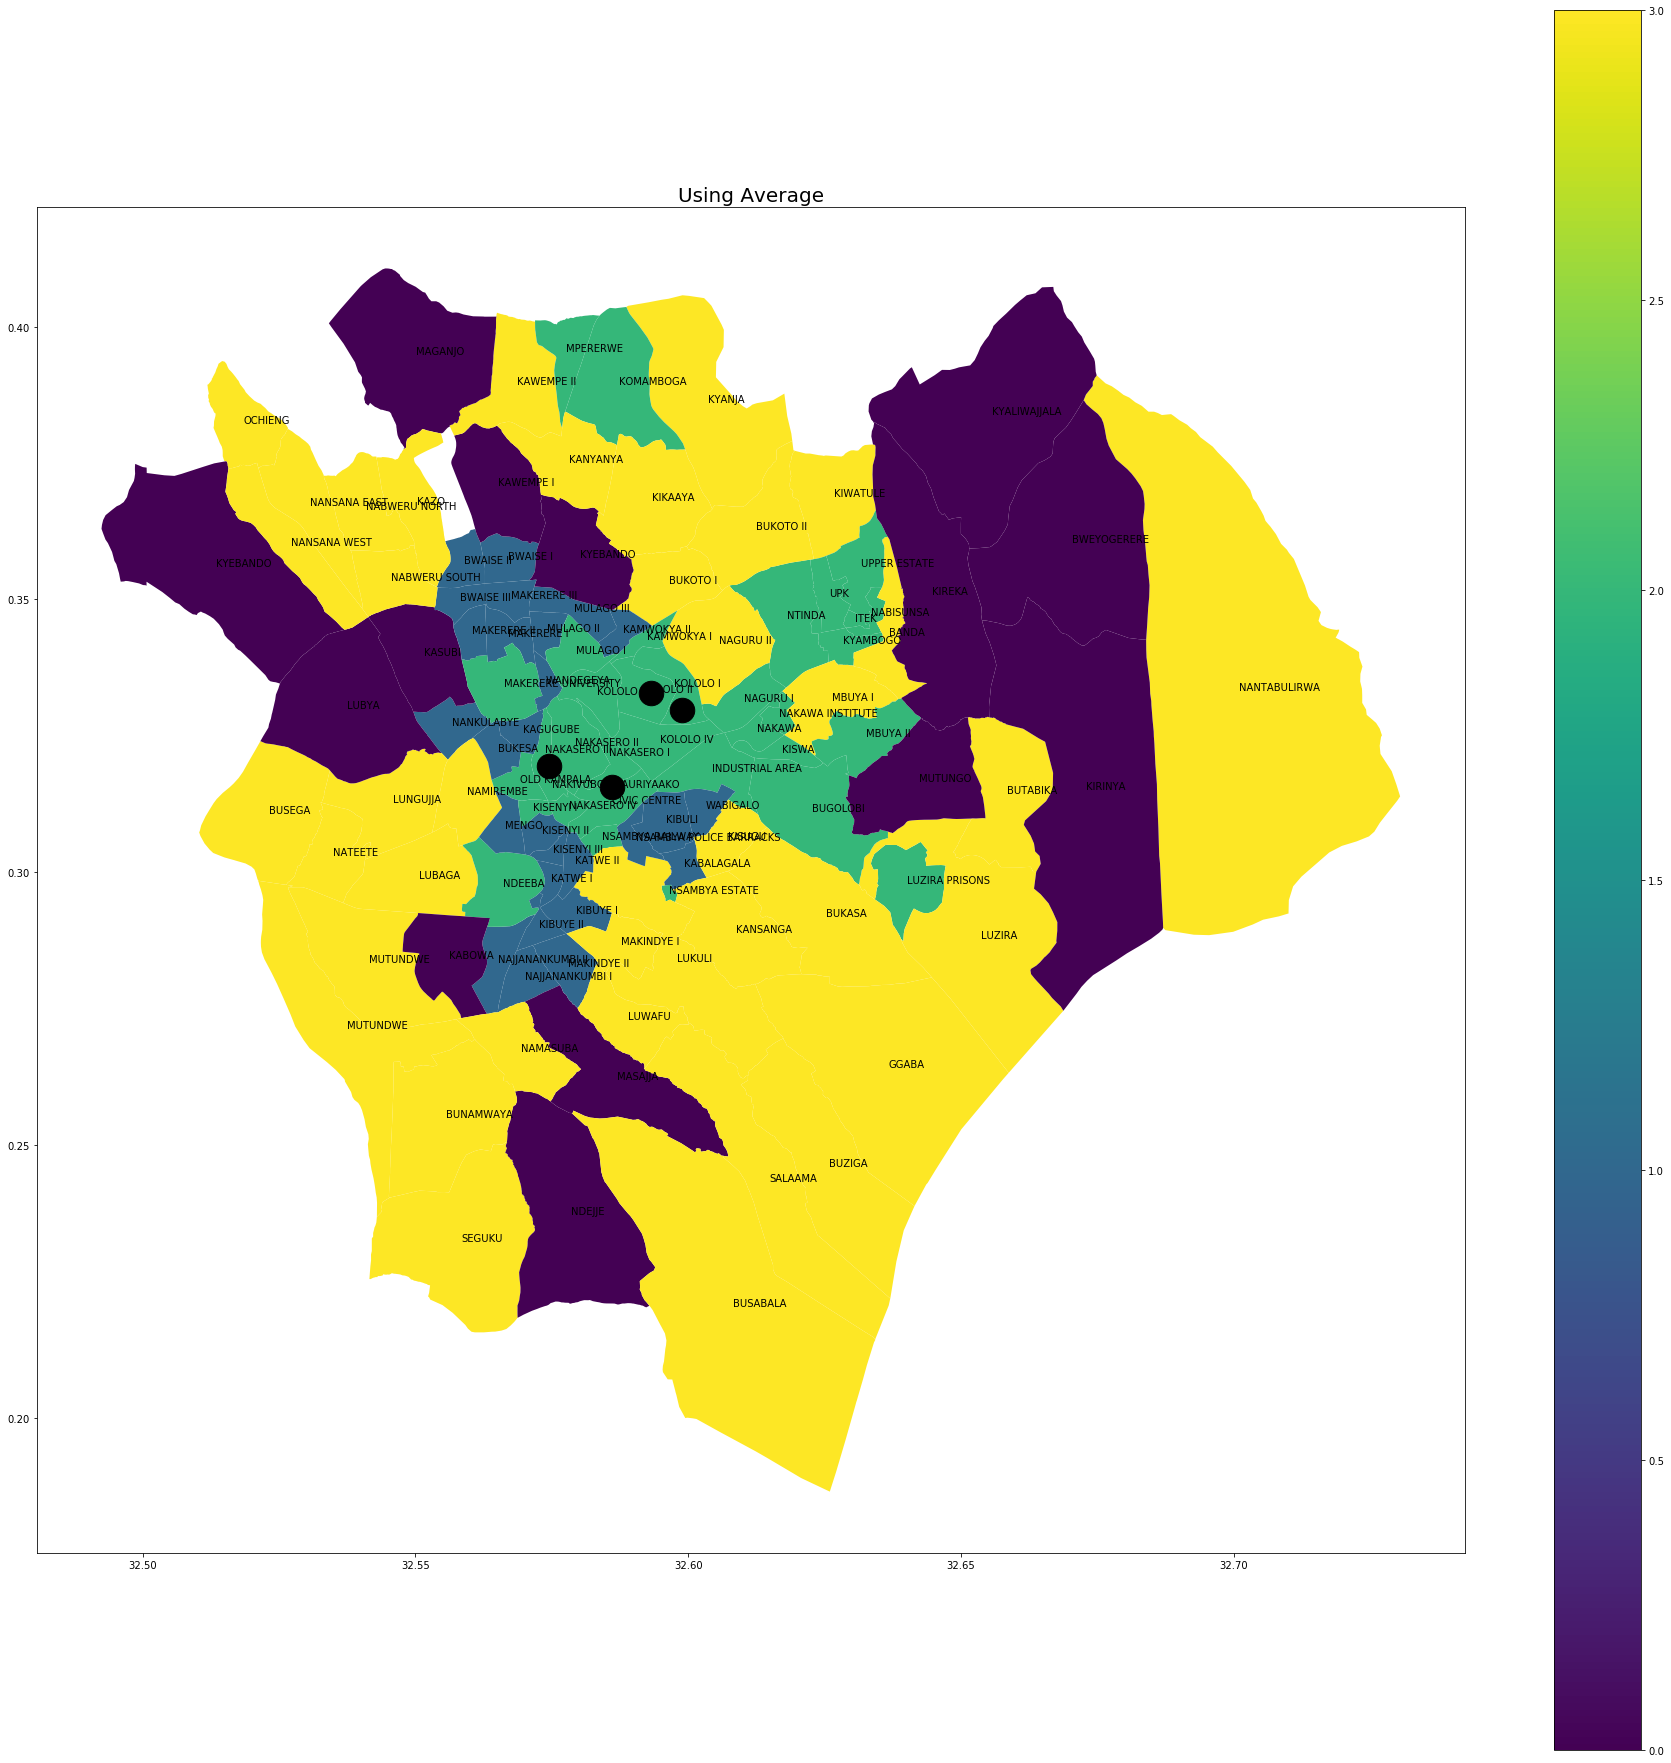

In [167]:
fig, ax = plt.subplots(figsize=(32, 32))
chart_title =  'Using Average' #
plt.title(chart_title,fontsize=20)
ax.set_aspect('equal')
data.plot(column='cluster', ax=ax, legend=True)
for i, txt in enumerate(data.parish):
    ax.annotate(txt, (data.long[i], data.lat[i]))
plt.scatter(data_cluster.long, data_cluster.lat, s=600, c='k')
plt.show()
fig.savefig('Hierarchical Clustering using Mean.png')

### Using max values

In [168]:
max_data_cluster =  data.groupby(['cluster']).max()

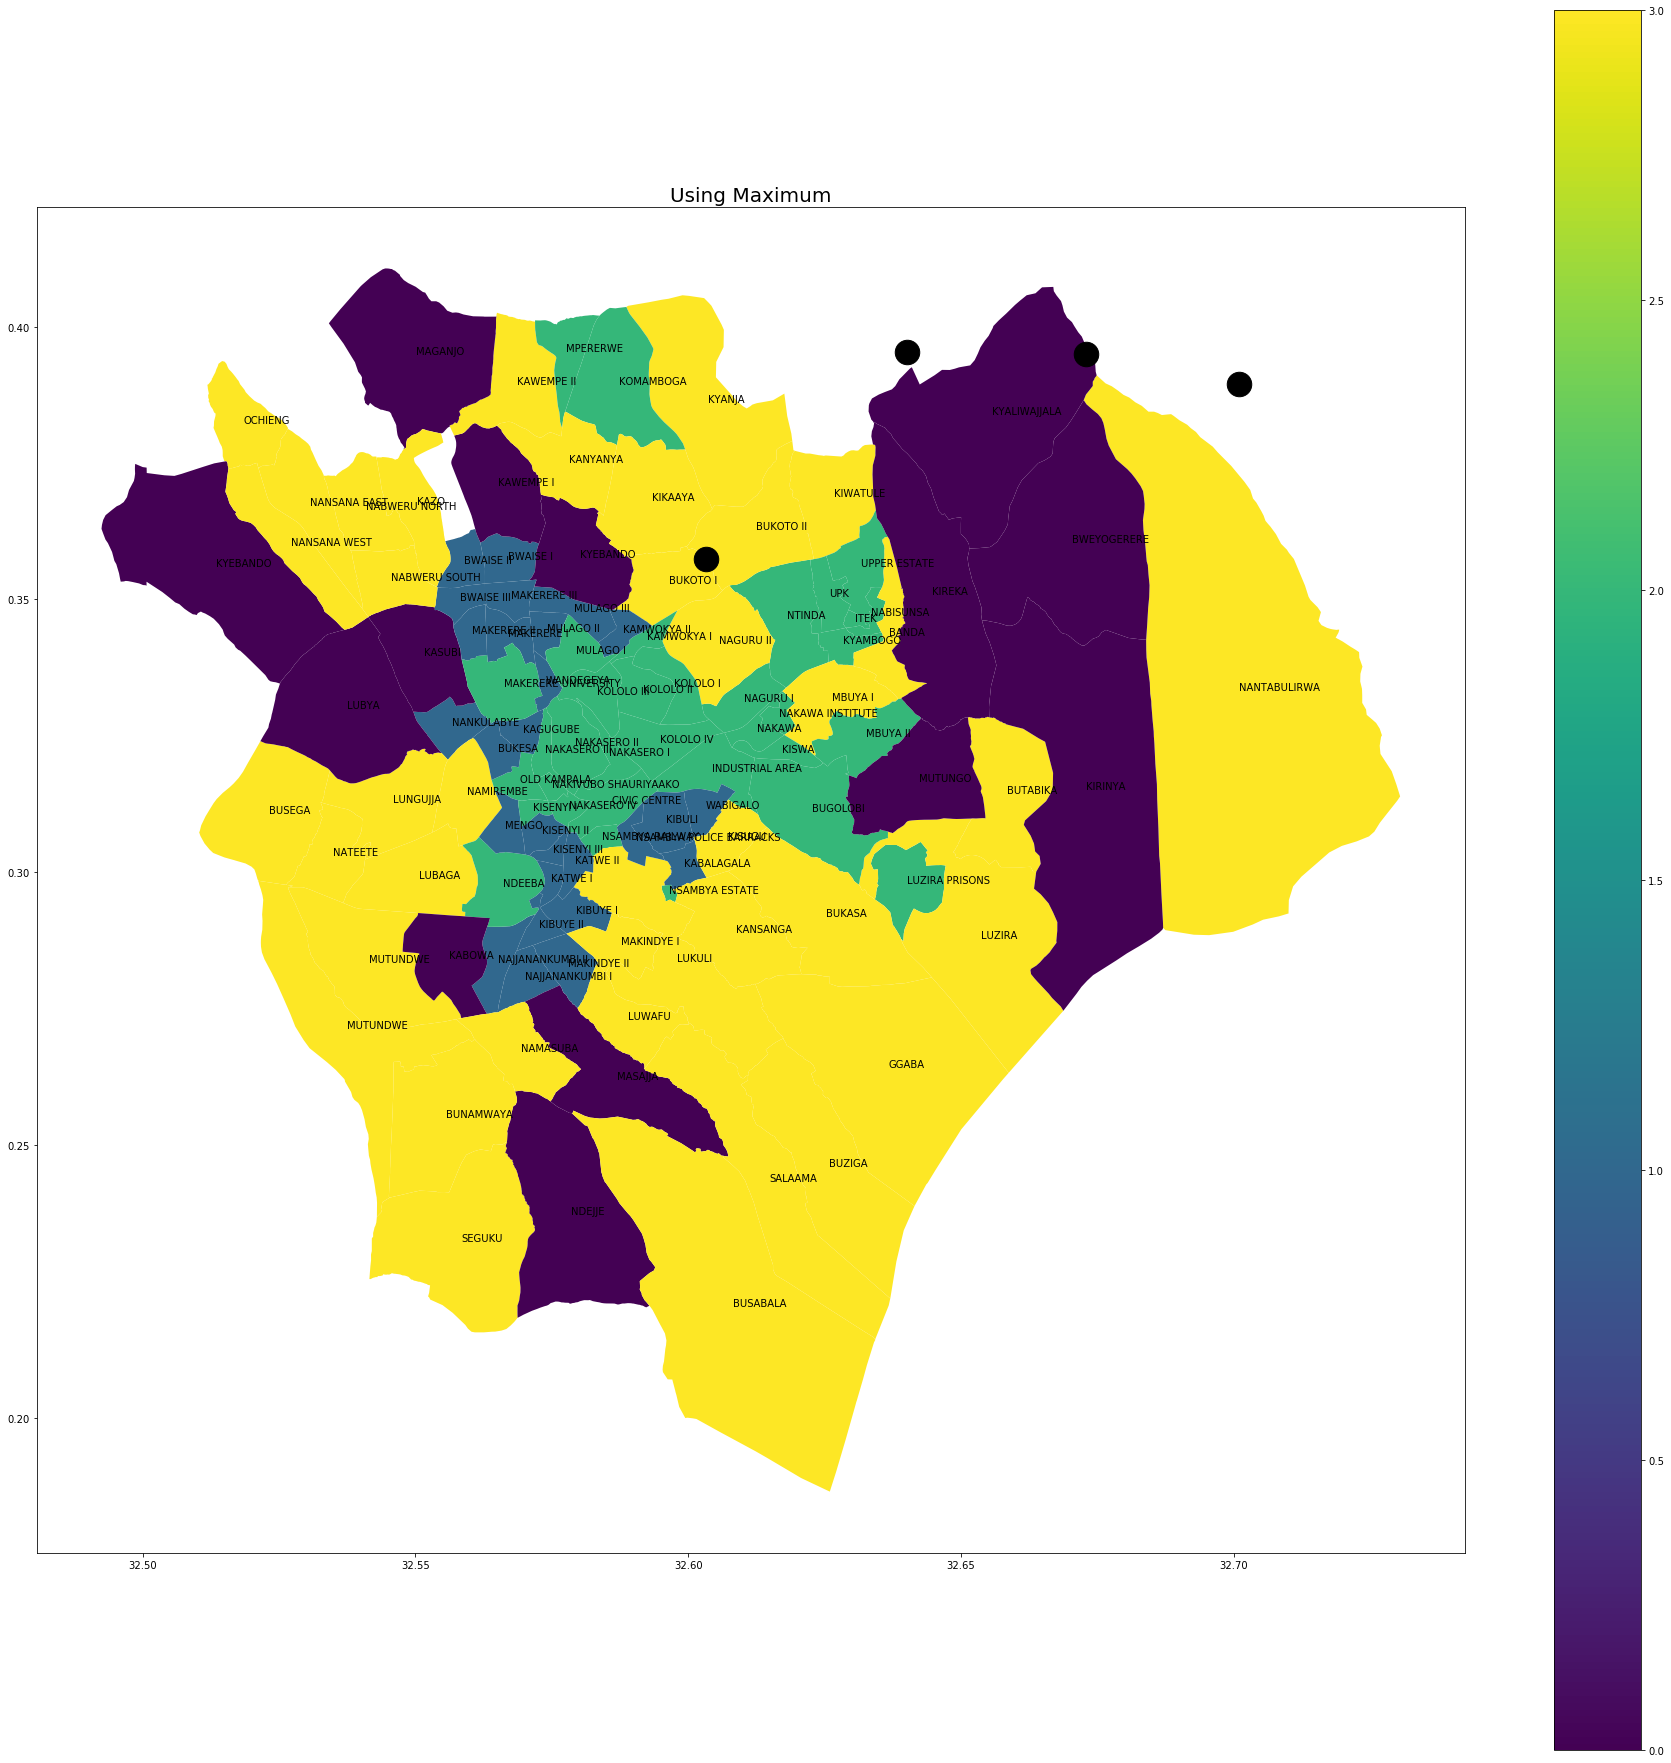

In [169]:
fig, ax = plt.subplots(figsize=(32, 32))
chart_title =  'Using Maximum' #
plt.title(chart_title,fontsize=20)
ax.set_aspect('equal')
data.plot(column='cluster', ax=ax, legend=True)
for i, txt in enumerate(data.parish):
    ax.annotate(txt, (data.long[i], data.lat[i]))
#plt.scatter(data_cluster.long, data_cluster.lat, s=600, c='k')
plt.scatter(max_data_cluster.long, max_data_cluster.lat, s=600, c='k')
plt.show()
fig.savefig('Hierarchical Clusters using Max.png')

In [170]:
min_data_cluster =  data.groupby(['cluster']).min()

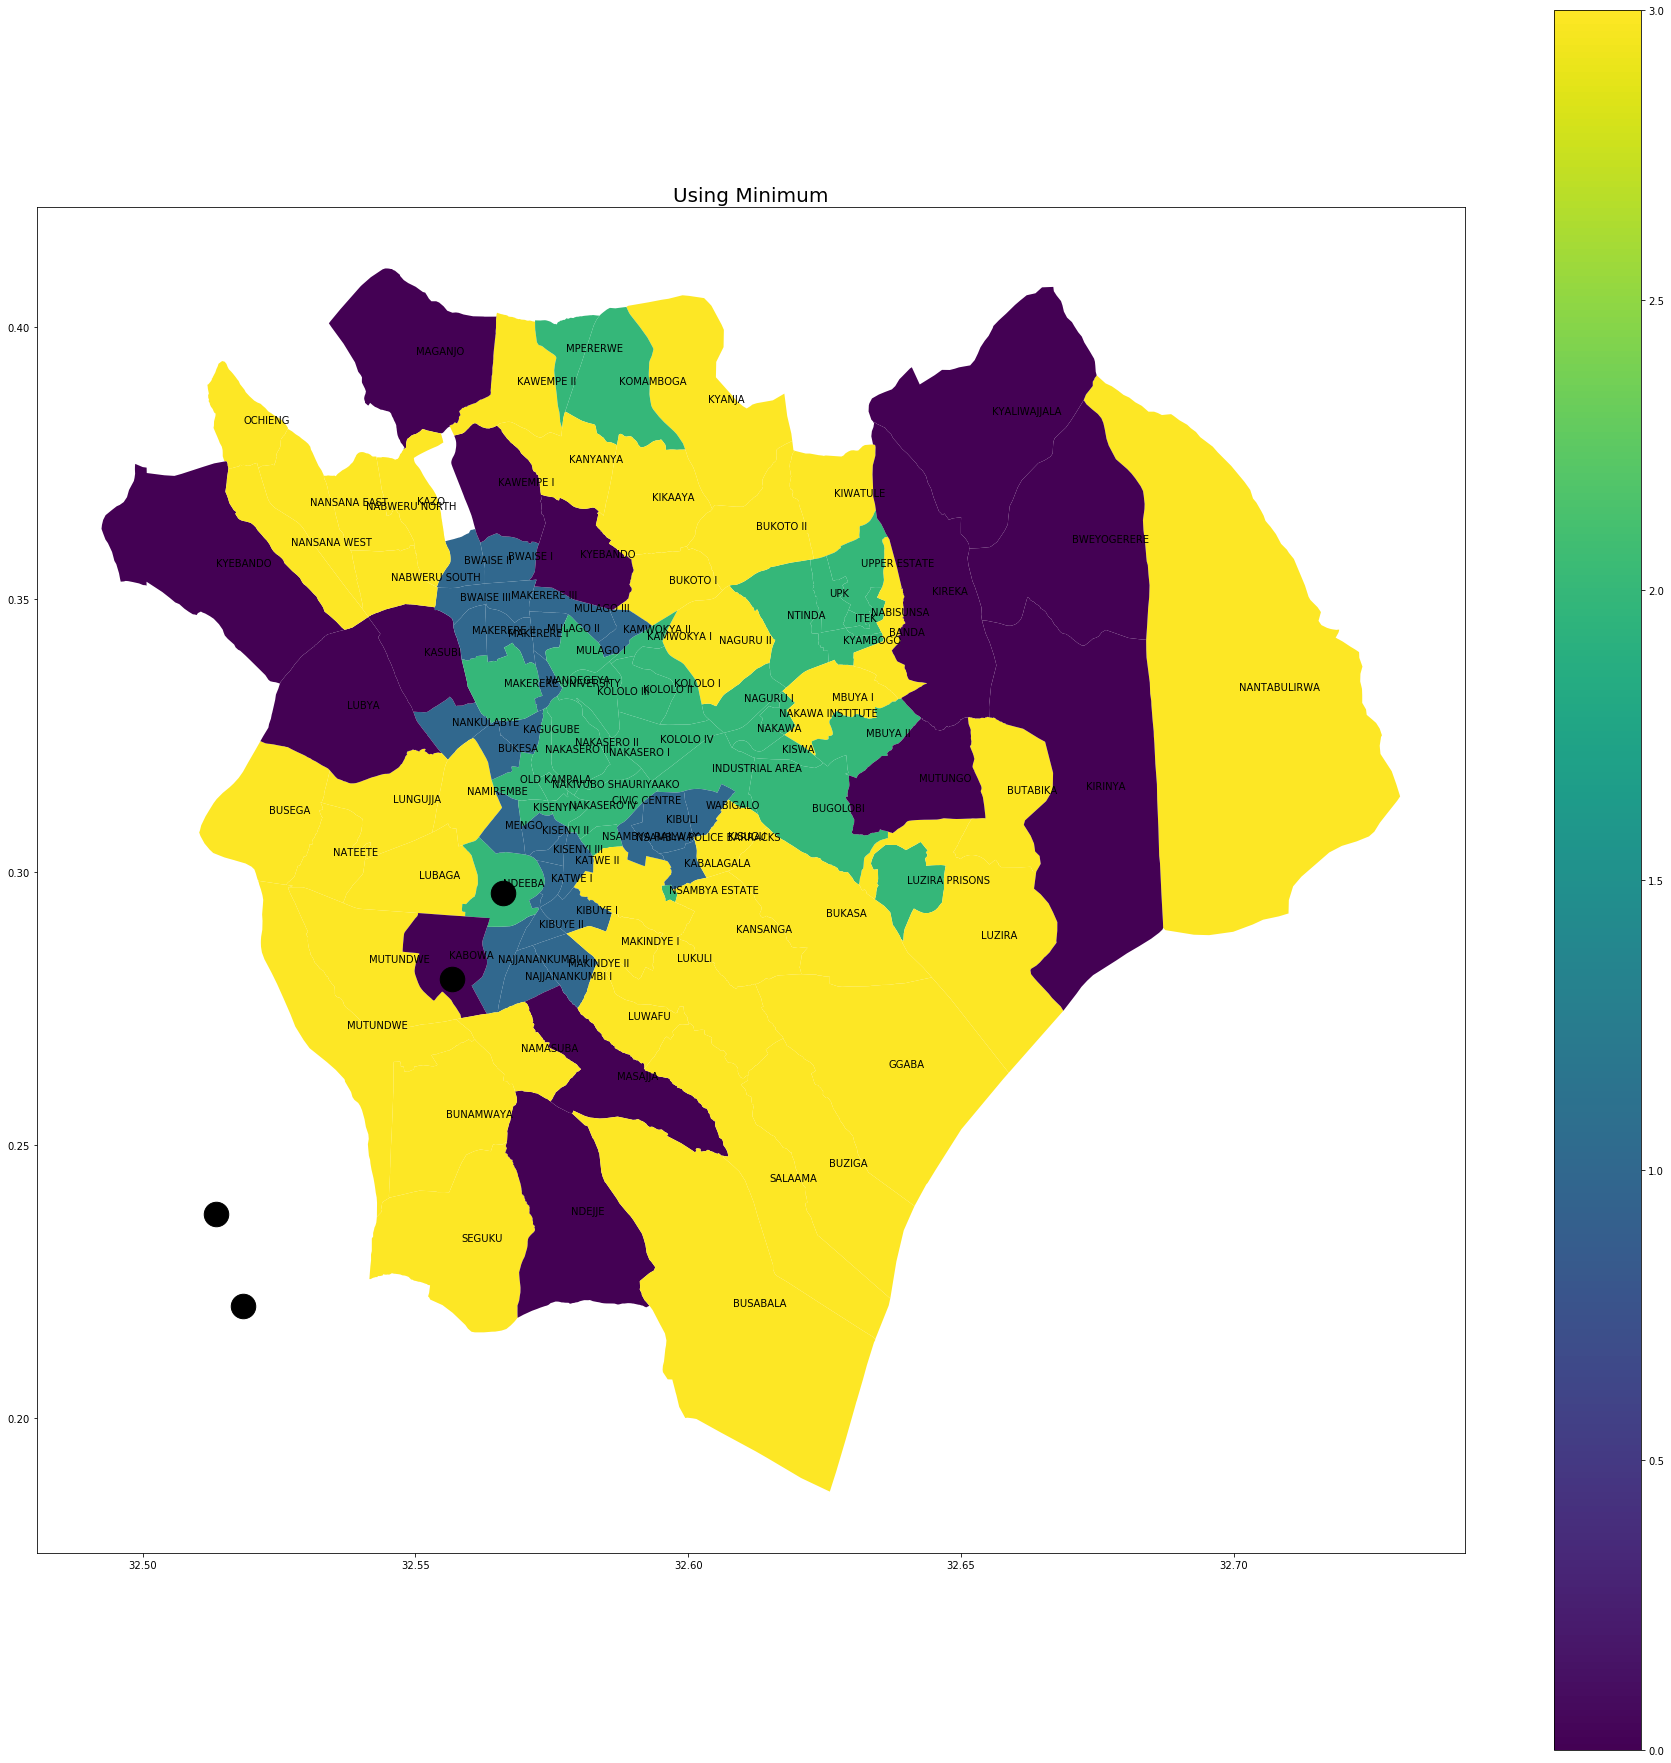

In [171]:
fig, ax = plt.subplots(figsize=(32, 32))
chart_title =  'Using Minimum' #
plt.title(chart_title,fontsize=20)
ax.set_aspect('equal')
data.plot(column='cluster', ax=ax, legend=True)
for i, txt in enumerate(data.parish):
    ax.annotate(txt, (data.long[i], data.lat[i]))
#plt.scatter(data_cluster.long, data_cluster.lat, s=600, c='k')
plt.scatter(min_data_cluster.long, min_data_cluster.lat, s=600, c='k')
plt.show()
fig.savefig('Kampala Clusters using Min.png')

### Using cluster centroid

In [173]:
from scipy.cluster.hierarchy import centroid, fcluster
from scipy.spatial.distance import pdist

In [172]:
X_dist = kmeans.transform(X_scaled)**2

NameError: name 'kmeans' is not defined

In [43]:
distances = X_dist.sum(axis=1).round(2)
len(distances)

114

In [47]:
data['distance_from_centroid'] = distances

In [48]:
data.head(2)

,index,district,subcounty,parish,population,households,long,lat,km2,area,...,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid,cluster,distances,distance_from_centroid
0,0,WAKISO,WAKISO,KYEBANDO,61051,14763,32.513362,0.356149,10.501383,10.412916,...,4.14,10.85,9.75,0.19,0.17,"POLYGON ((32.52529 0.33488, 32.52572 0.33540, ...",POINT(32.5133620505223 0.356148577052009),4,2.460564e+10,2.460564e+10
1,1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,32.700915,0.333435,36.709773,36.376969,...,4.45,3.44,3.01,0.57,0.50,"POLYGON ((32.72674 0.32632, 32.72609 0.32735, ...",POINT(32.7009147194484 0.333434596471355),7,1.619911e+10,1.619911e+10


In [50]:
max_data_cluster =  data.groupby(['cluster']).max()
max_data_cluster.head(2)

,index,district,subcounty,parish,population,households,long,lat,km2,area,...,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,centroid,distances,distance_from_centroid
cluster,,,,,,,,,,,,,,,,,,,,,
0,90,KAMPALA,NAKAWA DIVISION,UPPER ESTATE,5992,1506,32.633537,0.395425,3.912260,3.877850,...,7394.43,2841.54,95.17,80.11,60.62,8.49,4.48,POINT(32.6335367318833 0.347064749892051),3.166067e+10,3.166067e+10
1,111,WAKISO,RUBAGA DIVISION,SALAAMA,39984,10132,32.614810,0.310780,21.154149,20.969131,...,7276.12,1914.75,4.05,16.67,13.57,0.42,0.37,POINT(32.6148098770656 0.24336217810843),1.420874e+10,1.420874e+10


In [51]:
latitudes =[]
longitudes = []
for distance in max_data_cluster['distance_from_centroid']:
    latitude = data.loc[data['distance_from_centroid']==distance, 'lat'].iloc[0]
    longitude = data.loc[data['distance_from_centroid']==distance, 'long'].iloc[0]
    latitudes.append(latitude)
    longitudes.append(longitude)

In [52]:
print (len(latitudes))
print (len(longitudes))

15
15


In [53]:
max_latitudes = pd.Series(latitudes)
max_longitudes = pd.Series(longitudes)

In [54]:
max_df = pd.concat([max_latitudes, max_longitudes], axis=1)
max_df.columns=['latitude', 'longitude']
max_df.head()

,latitude,longitude
0,0.306109,32.584200
1,0.220525,32.608197
2,0.298327,32.574835
3,0.351001,32.644751
4,0.330044,32.537465


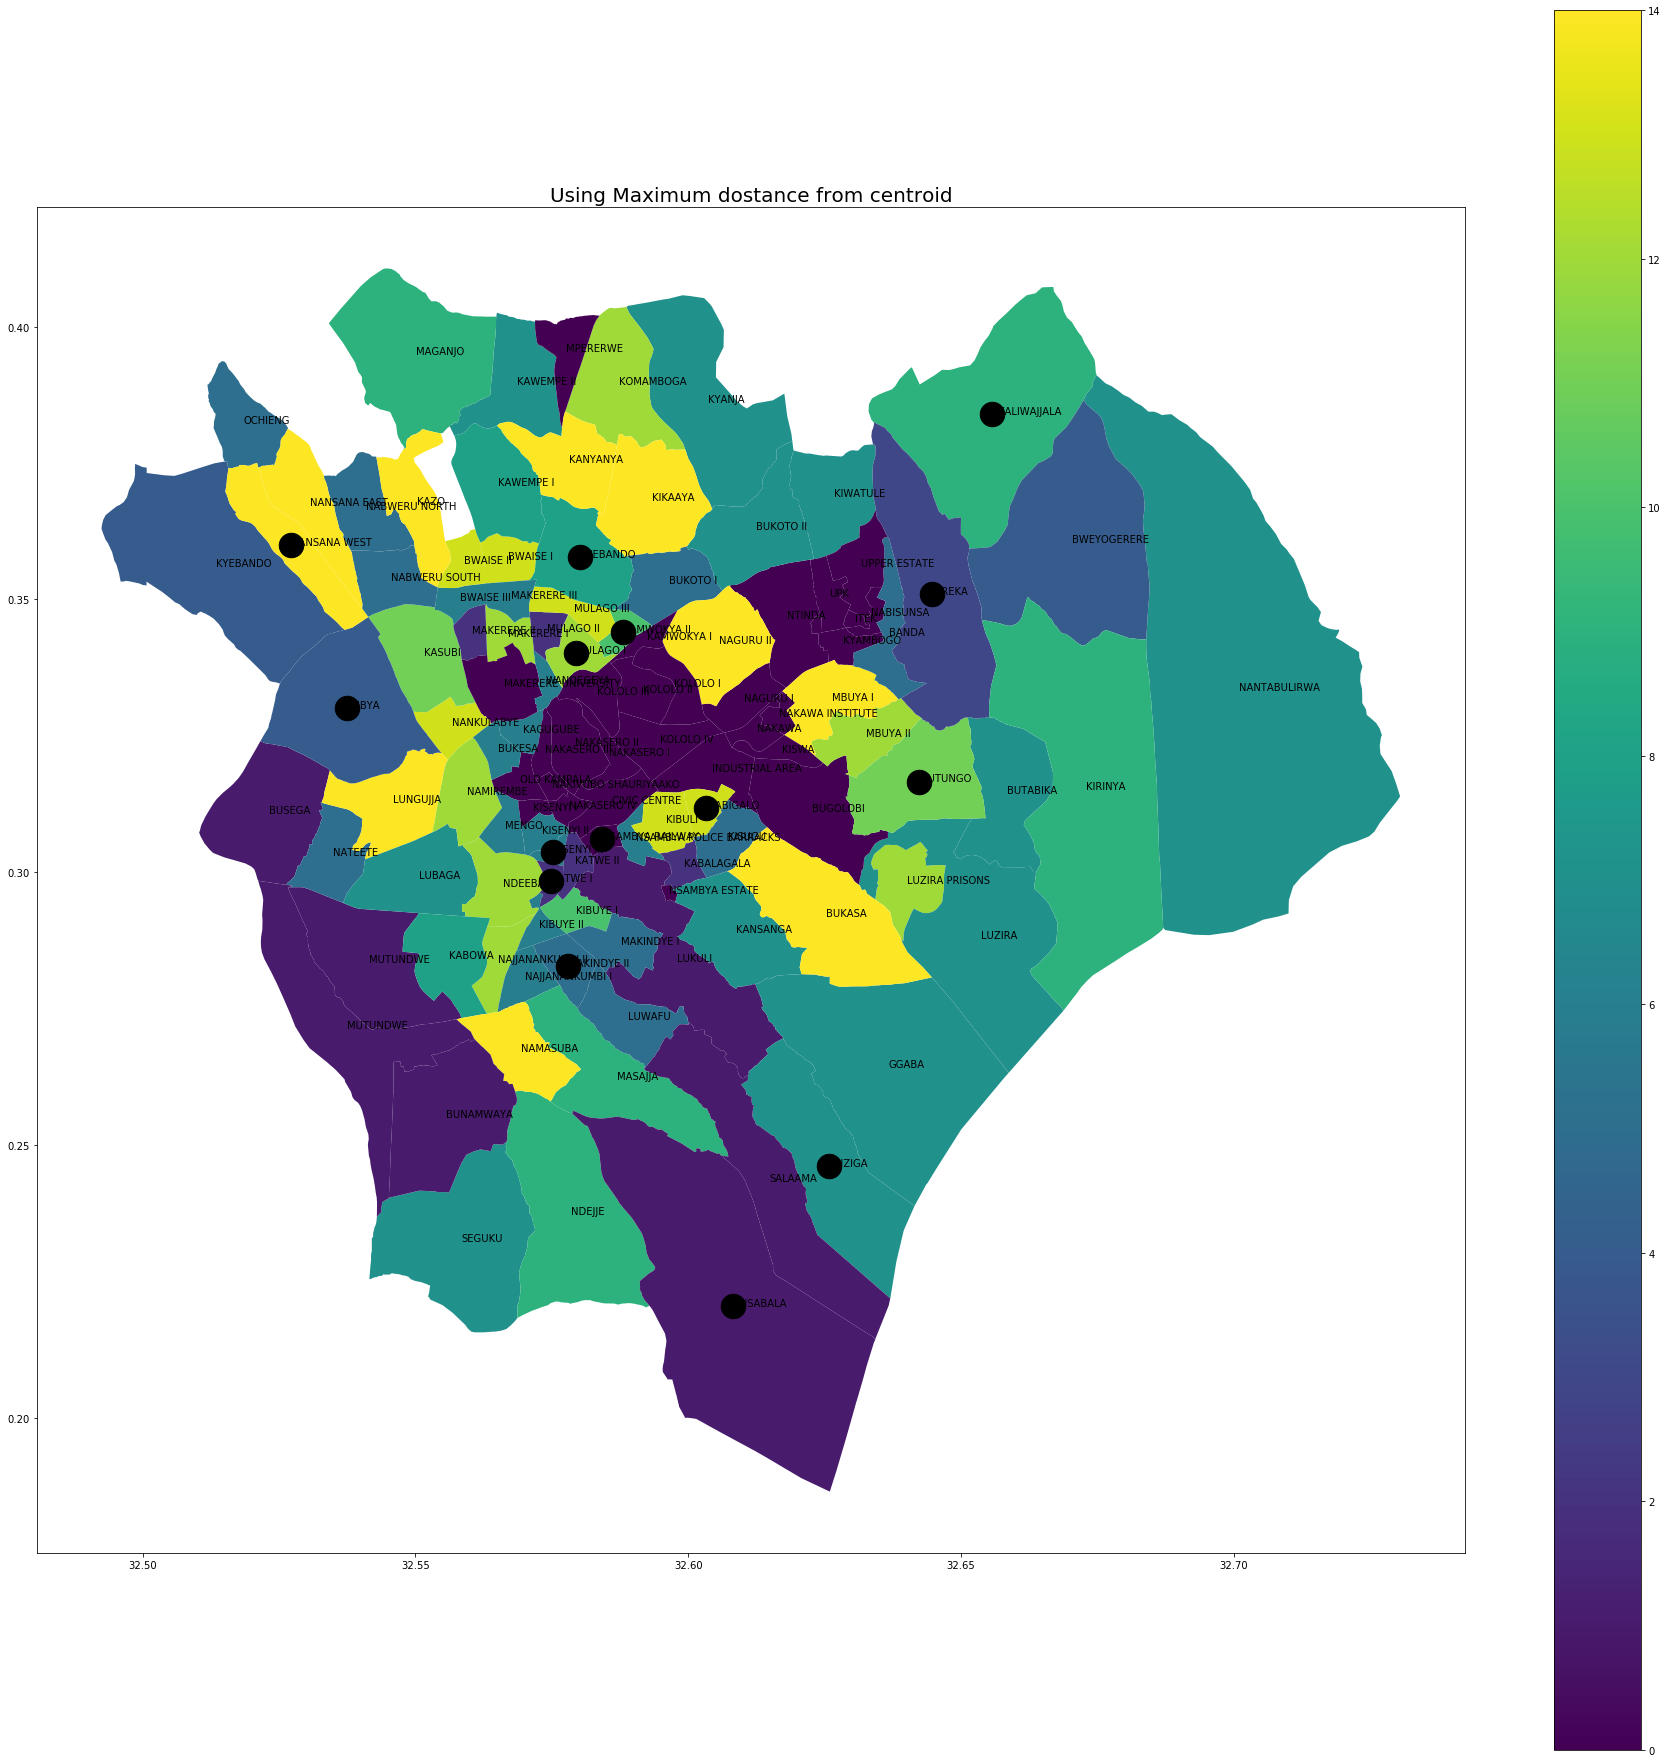

In [55]:
fig, ax = plt.subplots(figsize=(32, 32))
chart_title =  'Using Maximum dostance from centroid' #
plt.title(chart_title,fontsize=20)
ax.set_aspect('equal')
data.plot(column='cluster', ax=ax, legend=True)
for i, txt in enumerate(data.parish):
    ax.annotate(txt, (data.long[i], data.lat[i]))
#plt.scatter(data_cluster.long, data_cluster.lat, s=600, c='k')
plt.scatter(max_df.longitude, max_df.latitude, s=600, c='k')
plt.show()
fig.savefig('Kampala Clusters using Furthest point from centroid.png')